# Overview

Understanding and predicting customer preferences is essential for tailoring banks' marketing efforts and driving higher customer engagement. Banks face challenges in determining the most relevant products for individual customers, especially when customer needs and preferences are influenced by numerous variables such as income, debt, loan amount, transaction history, and customer demographics. Predicting these preferences allows banks to provide personalized recommendations, improving customer satisfaction and fostering long-term relationships.

To address this challenge, we aim to develop a model that predicts individual customer preferences for banking products based on customer demographics, transaction history, and loan details. By analyzing these key factors, we can develop personalized recommendations for each customer, improving product targeting and customer experience. The model will be designed as a multi-label classification problem, where multiple products can be recommended for each customer based on their unique characteristics.

The key features influencing customer preferences include financial attributes such as income, debt, loan amount, and transaction history, as well as demographic features such as age, gender, and employment status. Transaction data provides insights into spending habits and financial priorities, while loan data gives context about a customer’s current and future financial commitments. Additionally, we will incorporate the results from customer segmentation to fine-tune the model’s predictions for specific customer groups. By leveraging customer segments as an additional feature, we can ensure that the recommendations are tailored to each segment's specific needs and behaviors.

Outline:
1. **Data Preprocessing**:
   - Aggregate the transaction data (transactions.csv) to summarise transaction behaviour per customer. This will include:
     - Average transaction amount
     - Transaction count/frequency
   - Aggregate the loan data (loans.csv) per customer. This will include:
      - Has active loans
      - Total loan amount
      - Number of loans
      - Average loan amount
   - Merge customer.csv the aggregated transactions and loans data using `customer_id` as the shared column.

2. **Exploratory Data Analysis (EDA)**:
   - Perform initial data exploration to understand distributions, correlations, and relationships between customer attributes (e.g., income, age, debt) and product preferences.
   - Visualize trends in aggregated transaction data (e.g., total spending, frequency) and loan data (e.g., loan amounts, loan types) to identify potential patterns that could indicate product interest.
   - Detect any outliers, anomalies, or biases that could negatively affect model performance.

3. **Feature Engineering**:
   - kiv, see whether need to scale or whether need new features (esp ratios bet financial attributes)
   - Include the customer segmentation results as an additional categorical feature

4. **Modeling**:
   - Since this is a multi-label classification problem, I will likely be using algorithms such as Random Forest or XGBoost

By developing this predictive model, the bank will be able to better understand customer preferences, allowing for personalized product recommendations, improved targeting of marketing campaigns, and more efficient allocation of resources. This will enable the bank to optimize marketing efforts by focusing on products most likely to meet individual customer needs, increase cross-selling opportunities, enhance customer loyalty, and ultimately drive a higher return on investment in marketing campaigns.



# Data Preprocessing

## Loading the data

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

project_root = os.getcwd()  
# Path to the processed data folder
path = os.path.join(project_root, "..", "..", "data", "processed")

# Load the CSV files
customer_df = pd.read_csv(os.path.join(path, "customer.csv"))
transactions_df = pd.read_csv(os.path.join(path, "transactions.csv"))
loans_df = pd.read_csv(os.path.join(path, "loans.csv"))
products_df = pd.read_csv(os.path.join(path, "products_owned.csv"))
customer_segments = pd.read_csv("../../customer_segmentation/customer_segments.csv")


## Data cleaning 

In [303]:
# Converting date features to datetime
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
loans_df["due_date"] = pd.to_datetime(loans_df["due_date"])
loans_df["paid_off_date"] = pd.to_datetime(loans_df["paid_off_date"])

# Creating binary feature for loan status
loans_df["is_paid_off"] = loans_df["paid_off_date"].notna().astype(int)

transactions_df
#loans_df.head()

,transaction_id,customer_id,transaction_type,transaction_amt,transaction_date
0,316418,3715,Deposit,510.38,2024-06-14 16:06:14
1,696537,3715,Withdrawal,703.02,2023-03-19 17:14:15
2,232878,1239,Withdrawal,308.54,2024-07-06 11:30:21
3,912436,1239,Transfer,258.19,2024-01-16 01:24:59
4,983966,1239,Deposit,395.92,2024-03-23 12:27:46
...,...,...,...,...,...
6458,281958,3279,Withdrawal,457.44,2023-11-27 23:45:59
6459,600198,2112,Withdrawal,357.24,2023-01-01 21:32:25
6460,869108,2112,Deposit,403.47,2024-12-28 15:35:31
6461,245455,3100,Withdrawal,366.46,2023-06-27 00:45:24


## Data Aggregation

### Transactions table

In [304]:
# Aggregating the data per customer_id
aggregated_transactions = transactions_df.groupby('customer_id').agg(
    avg_transaction_amt=('transaction_amt', 'mean'),  # Average transaction amount
    transaction_count=('transaction_id', 'count')     # Count of transactions (frequency)
).reset_index()

# Calculate the number of unique months per customer
transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')

# Group by customer_id to get the count of unique months
unique_months = transactions_df.groupby('customer_id')['year_month'].nunique().reset_index(name='unique_month_count')

# Merge the results together
aggregated_transactions = pd.merge(aggregated_transactions, unique_months, on='customer_id', how='left')

# Calculate the average transactions per month
aggregated_transactions['avg_transactions_per_month'] = aggregated_transactions['transaction_count'] / aggregated_transactions['unique_month_count']

aggregated_transactions = aggregated_transactions[['customer_id', 'avg_transaction_amt', 'transaction_count', 'avg_transactions_per_month']]
aggregated_transactions

,customer_id,avg_transaction_amt,transaction_count,avg_transactions_per_month
0,3,99.895000,2,1.0
1,4,32.895000,2,1.0
2,5,108.130000,1,1.0
3,6,156.513333,3,1.0
4,8,28.010000,1,1.0
...,...,...,...,...
1857,3989,70.766667,3,1.0
1858,3990,243.715000,2,1.0
1859,3993,343.306667,3,1.0
1860,3996,376.244286,7,1.0


### Loans table


In [305]:
from datetime import datetime

# Convert relevant columns to datetime
loans_df['due_date'] = pd.to_datetime(loans_df['due_date'])
loans_df['paid_off_date'] = pd.to_datetime(loans_df['paid_off_date'], errors='coerce')

# 1. Has active loans
loans_df['has_active_loan'] = loans_df['paid_off_date'].isnull()

# 2. Total loan amount
total_loan_amount = loans_df.groupby('customer_id')['loan_amount'].sum().reset_index(name='total_loan_amount')

# 3. Number of loans
num_loans = loans_df.groupby('customer_id')['loan_id'].count().reset_index(name='num_loans')

# 4. Average loan amount
avg_loan_amount = loans_df.groupby('customer_id')['loan_amount'].mean().reset_index(name='avg_loan_amount')

# 5. Aggregate has active loans
active_loans = loans_df.groupby('customer_id')['has_active_loan'].max().reset_index(name='has_active_loans')

# Merge all aggregated data
loan_aggregates = total_loan_amount.merge(num_loans, on='customer_id') \
                                   .merge(avg_loan_amount, on='customer_id') \
                                   .merge(active_loans, on='customer_id') 
# Display the result
loan_aggregates
#loan_aggregates.describe()


,customer_id,total_loan_amount,num_loans,avg_loan_amount,has_active_loans
0,1,43000.0,3,14333.333333,True
1,3,33000.0,3,11000.000000,False
2,4,36000.0,3,12000.000000,False
3,5,46300.0,3,15433.333333,False
4,6,18800.0,3,6266.666667,False
...,...,...,...,...,...
2635,3993,41600.0,3,13866.666667,False
2636,3995,44550.0,3,14850.000000,True
2637,3997,30850.0,3,10283.333333,False
2638,3998,35600.0,3,11866.666667,False


### Final table

In [306]:
# Select relevant rows from customers_df
customer_df = customer_df[['customer_id', 'age', 'job', 'marital', 'education', 'default', 'balance', 'debt', 'income', 'dependents']]

# Merge customer_df with loan_aggregates
merged_data = pd.merge(customer_df, loan_aggregates, on="customer_id", how="left")

# Merge the result with aggregated_transactions
merged_data = pd.merge(merged_data, aggregated_transactions, on="customer_id", how="left")

# Merge the result with customer_segments
merged_data = pd.merge(merged_data, customer_segments, on="customer_id", how="left")

# Merge the result with products_df
merged_data = pd.merge(merged_data, products_df, on="customer_id", how="left")

# Check the merged data
df = merged_data
df

,customer_id,age,job,marital,education,default,balance,debt,income,dependents,...,has_active_loans,avg_transaction_amt,transaction_count,avg_transactions_per_month,Segment,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
0,217,33,unemployed,single,primary,1,-23869.04,15283.08,277.46,1,...,True,23.580000,1.0,1.0,At risk / inactive customers,0,0,1,1,0
1,179,32,retired,single,secondary,1,-16434.66,12630.49,716.15,3,...,True,50.200000,1.0,1.0,At risk / inactive customers,1,1,1,1,0
2,81,20,unemployed,single,secondary,1,-11910.44,21609.58,539.38,3,...,True,42.390000,1.0,1.0,High-value,1,0,1,0,0
3,50,35,unemployed,single,tertiary,1,-10332.25,47532.55,269.77,3,...,NaN,NaN,NaN,NaN,High-value,0,0,0,1,0
4,13,35,student,single,secondary,1,-8003.47,36324.75,522.33,1,...,True,29.010000,1.0,1.0,At risk / inactive customers,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3281,37,unknown,married,secondary,0,98279.81,36289.47,27848.66,2,...,True,NaN,NaN,NaN,Budget-conscious,1,1,1,1,0
3996,3101,43,unknown,married,secondary,0,129681.74,10337.89,28432.42,2,...,True,3089.786667,6.0,1.0,Budget-conscious,1,1,1,0,0
3997,3349,61,unknown,married,tertiary,0,164303.59,8223.83,29211.87,3,...,True,NaN,NaN,NaN,Budget-conscious,1,1,1,1,1
3998,2157,48,unknown,married,unknown,0,169448.44,10391.25,31063.57,1,...,False,NaN,NaN,NaN,Budget-conscious,1,0,0,0,1


## Exploratory Data Analysis

In [307]:
# Summary statistics for numerical features
df.describe()


,customer_id,age,default,balance,debt,income,dependents,total_loan_amount,num_loans,avg_loan_amount,avg_transaction_amt,transaction_count,avg_transactions_per_month,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,2640.000000,2640.0,2640.000000,1862.000000,1862.000000,1862.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,39.802000,0.161250,1955.631387,25536.410247,4926.078810,2.339500,37255.994318,3.0,12455.565025,368.551921,3.470999,1.077330,0.509750,0.669250,0.275500,0.537750,0.438750
std,1154.844867,10.342608,0.367807,7637.884812,24517.833775,3288.695279,1.299485,13556.246377,0.0,4530.330416,292.278391,2.359648,0.178828,0.499967,0.470542,0.446822,0.498635,0.496296
min,1.000000,18.000000,0.000000,-23869.040000,1007.770000,200.470000,0.000000,6275.000000,3.0,2091.666667,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,70.605000,10315.447500,2692.537500,1.000000,26800.000000,3.0,9000.000000,173.478750,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,354.820000,18392.535000,4082.075000,2.000000,36500.000000,3.0,12166.666667,295.566250,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3000.250000,47.000000,0.000000,1392.977500,32017.870000,6256.390000,3.000000,46000.000000,3.0,15352.083333,475.458214,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4000.000000,77.000000,1.000000,202759.360000,421994.640000,31448.860000,5.000000,86500.000000,3.0,28833.333333,3089.786667,16.000000,2.142857,1.000000,1.000000,1.000000,1.000000,1.000000


The features num_loans, avg_loan_amount, transaction_count, avg_transaction_amt, and avg_transactions_per_month exhibit a significant amount of missing data. We will first assess their correlation with the target variables before deciding whether to drop these features or impute the missing values.

Furthermore, the features balance and debt contain extreme values, indicating the presence of outliers. To mitigate the risk of overfitting, we will consider capping or trimming these extreme values. Additionally, both balance and debt display a right-skewed distribution (i.e., mean > median). This skewness could lead to uneven splits in tree-based models. To improve model interpretability and performance, we will apply a log transformation to these features.

In [308]:
# Capping Extreme Values
# Define a function to cap values at the 1st and 99th percentiles
def cap_outliers(df, col_name):
    lower_percentile = df[col_name].quantile(0.01)  # 1st percentile
    upper_percentile = df[col_name].quantile(0.99)  # 99th percentile
    
    df[col_name] = df[col_name].clip(lower=lower_percentile, upper=upper_percentile)
    
# Apply to 'balance' and 'debt'
cap_outliers(df, 'balance')
cap_outliers(df, 'debt')

# Apply Log Transformation to Skewed Features
# To avoid issues with negative values or zero, we shift the values by a constant before applying log
def log_transform(df, col_name):
    # Apply log transformation while avoiding log(0) or log(negative) by adding a constant
    df[col_name] = np.log1p(df[col_name])  # np.log1p does log(1 + x), which handles zeros well

# Apply log transformation to 'balance' and 'debt' (if they are positively skewed)
log_transform(df, 'balance')
log_transform(df, 'debt')

# Check the transformed values
df[['balance', 'debt']].describe()


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,balance,debt
count,3355.000000,4000.000000
mean,6.330220,9.810390
std,1.683497,0.815035
min,0.792993,7.831857
25%,5.176319,9.241495
50%,6.332320,9.819754
75%,7.469916,10.374081
max,10.202564,11.685510


### Transactions vs product ownership
Visualise the relationships between avg_transaction_amt and transaction_count with each product

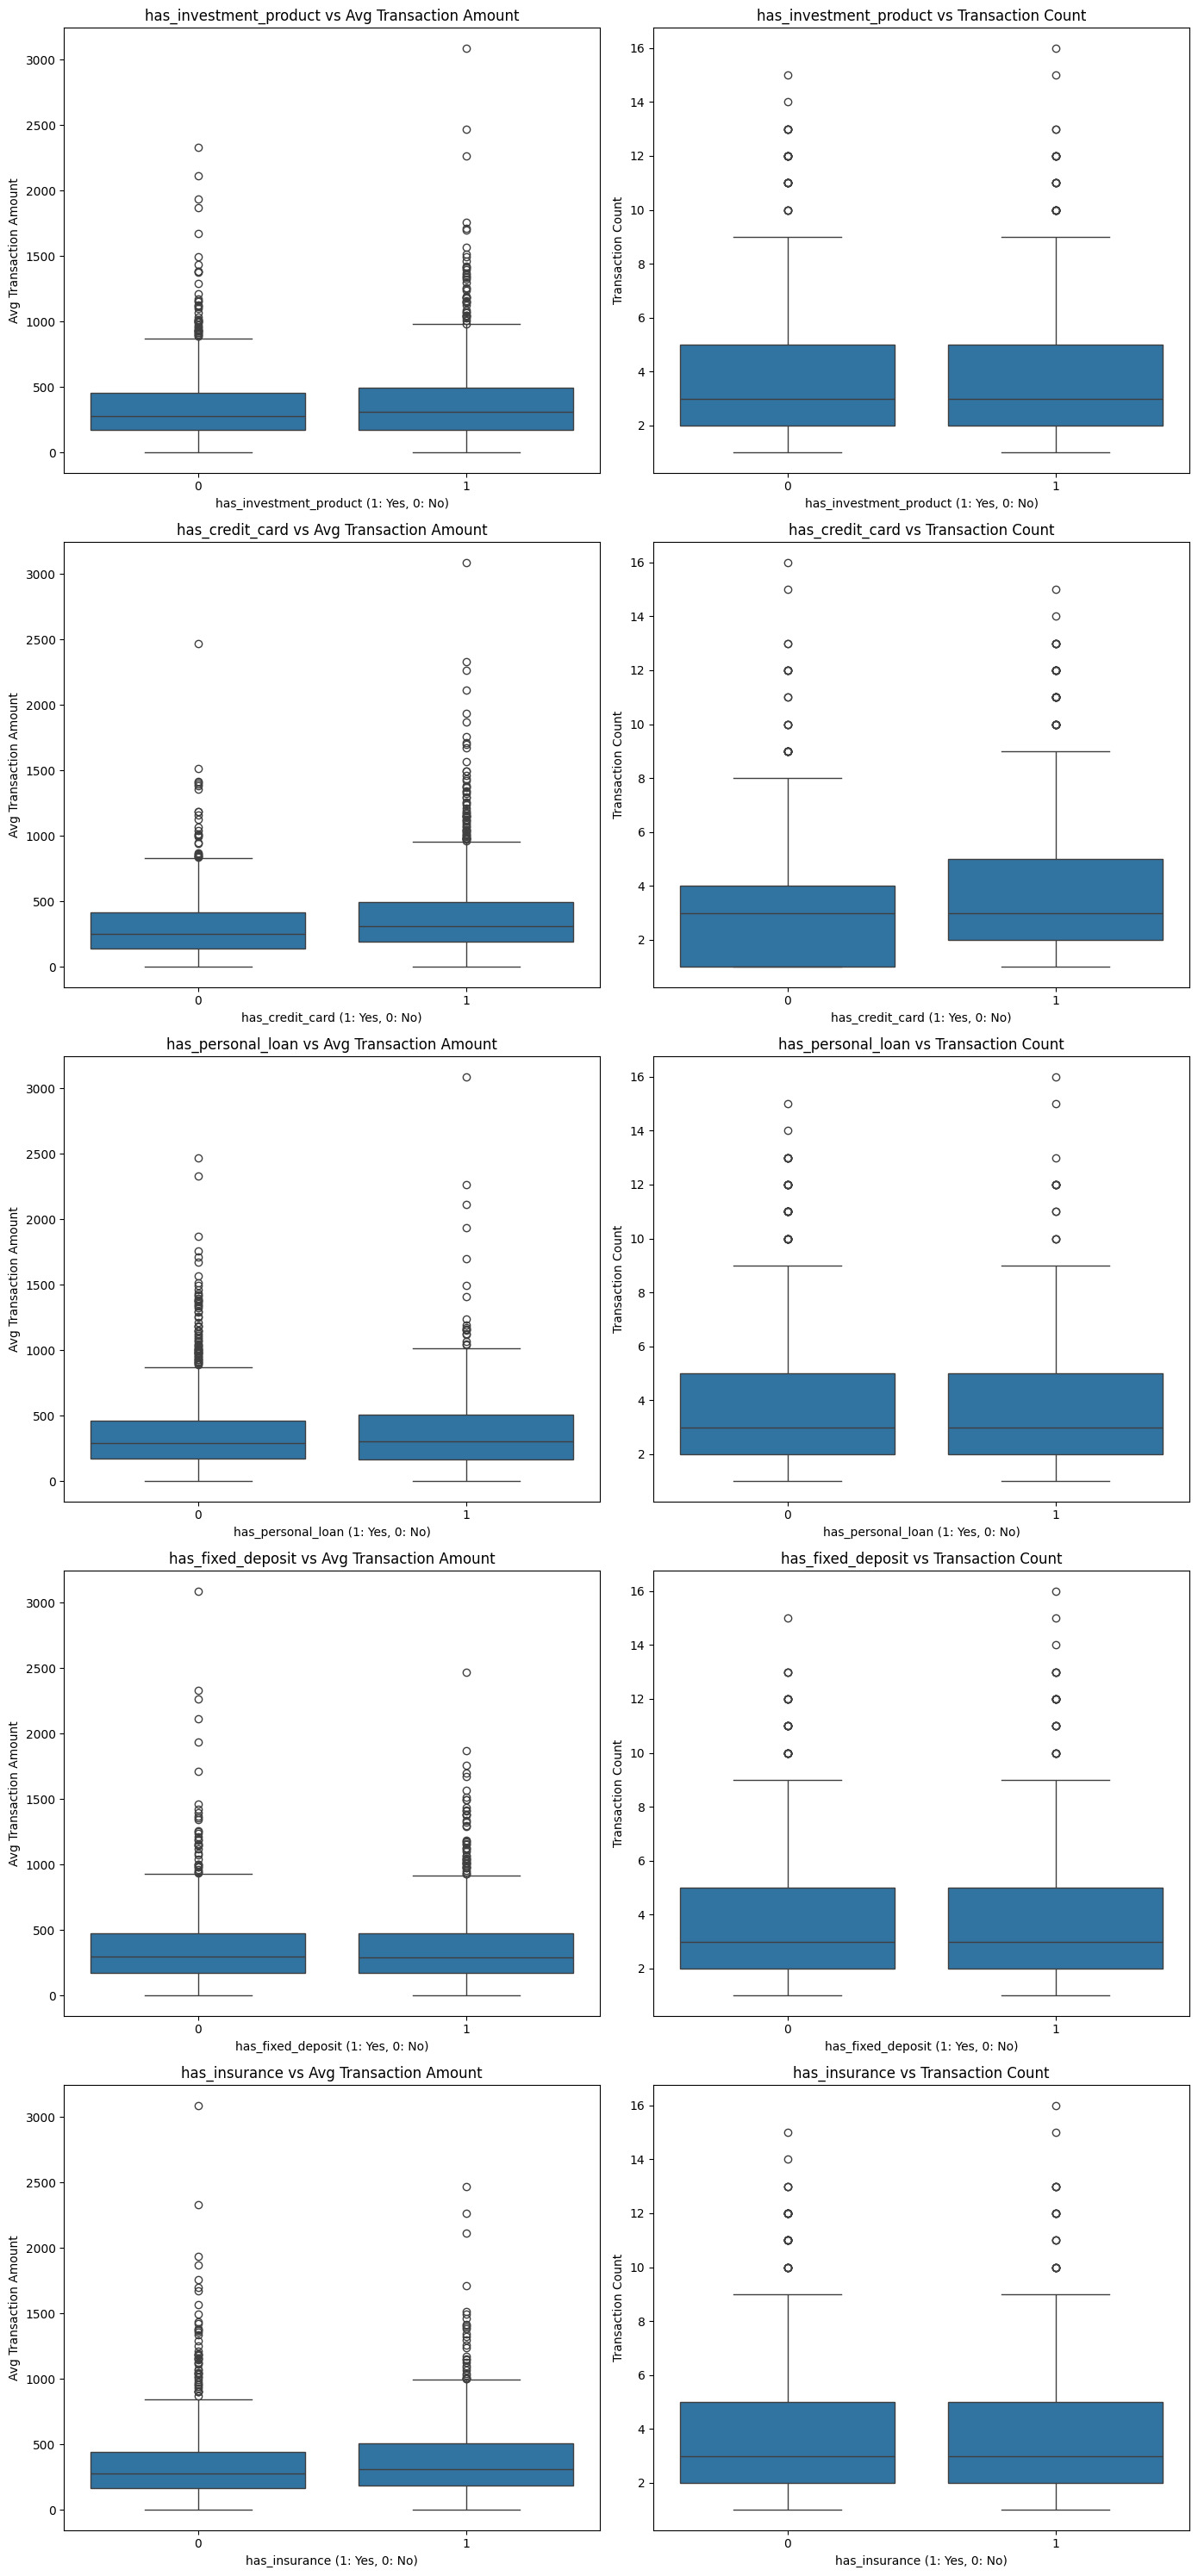

In [309]:
# List of product ownership columns
product_columns = [
    "has_investment_product", "has_credit_card",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

# Plot relationships for each product ownership
fig, axes = plt.subplots(len(product_columns), 2, figsize=(14, 6 * len(product_columns)))

for i, product in enumerate(product_columns):
    # Plot the relationship between product ownership and avg_transaction_amt
    sns.boxplot(x=product, y='avg_transaction_amt', data=merged_data, ax=axes[i, 0])
    axes[i, 0].set_title(f'{product} vs Avg Transaction Amount')
    axes[i, 0].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 0].set_ylabel('Avg Transaction Amount')
    
    # Plot the relationship between product ownership and transaction_count
    sns.boxplot(x=product, y='transaction_count', data=merged_data, ax=axes[i, 1])
    axes[i, 1].set_title(f'{product} vs Transaction Count')
    axes[i, 1].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()


Moreover, the box plots indicate that the available transaction data does not show a significant impact on whether a customer owns any of the products, hence we will exclude it from the modeling process.

### Loans vs product ownership
Visualise the relationships between each aggregated loan feature with each product

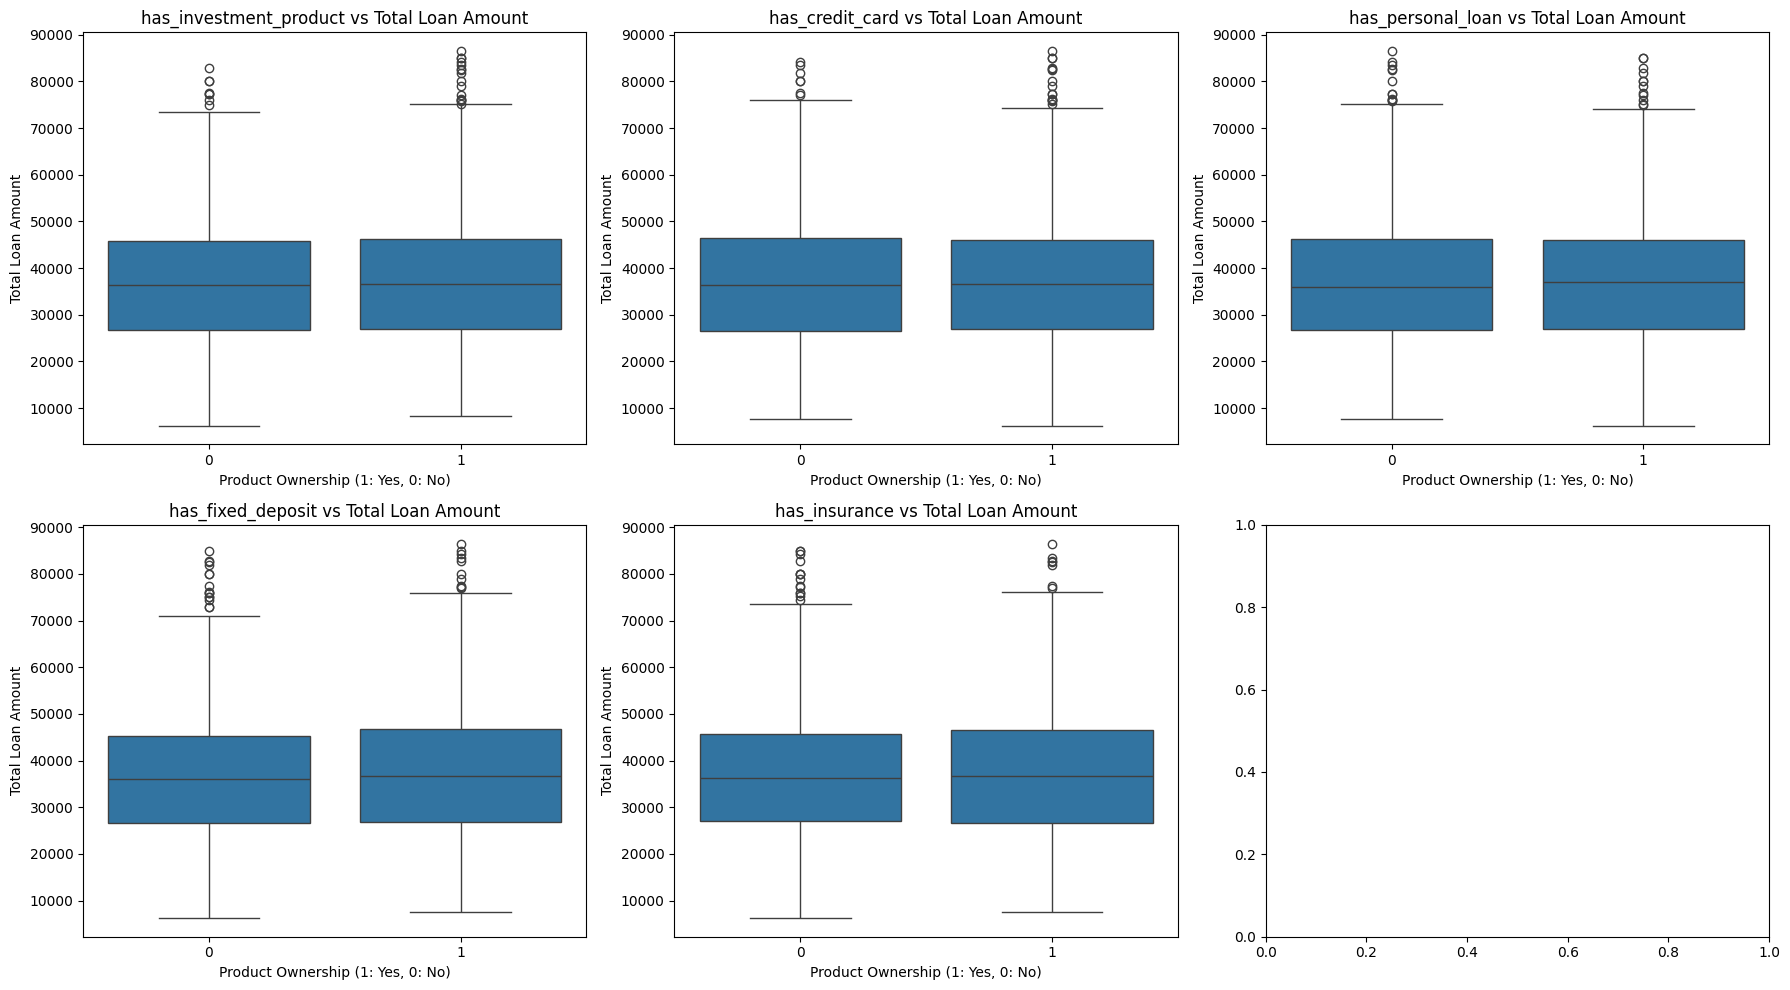

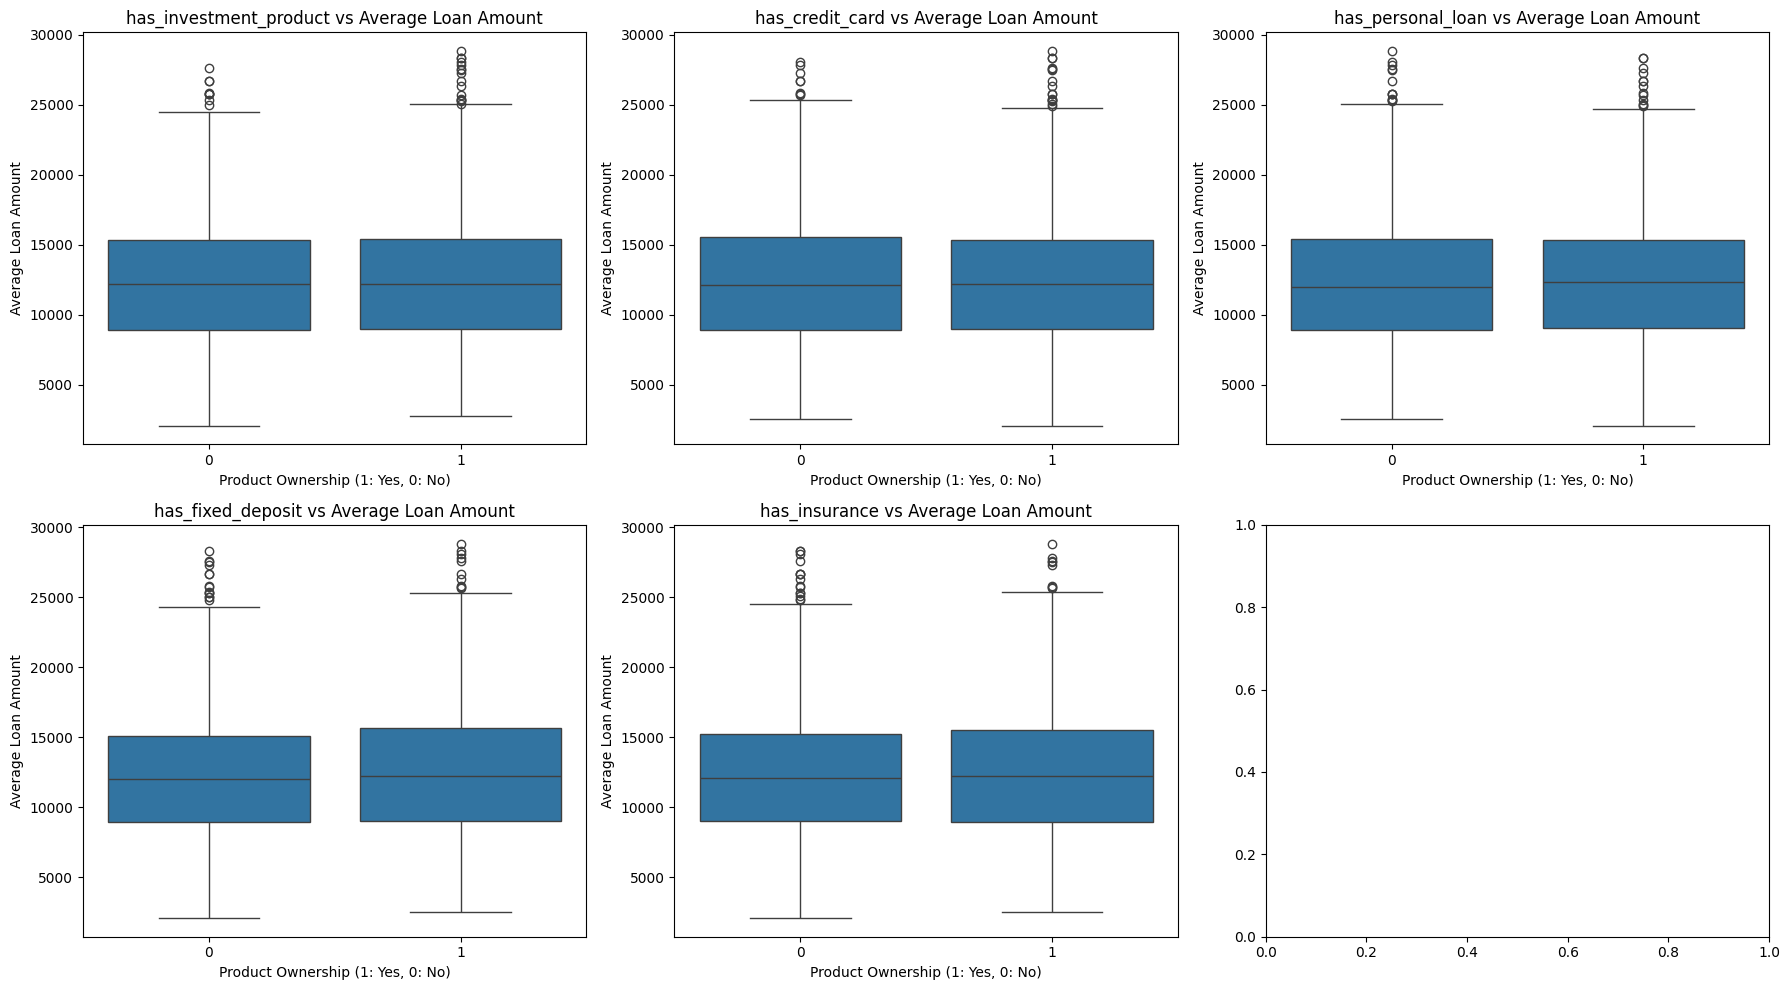

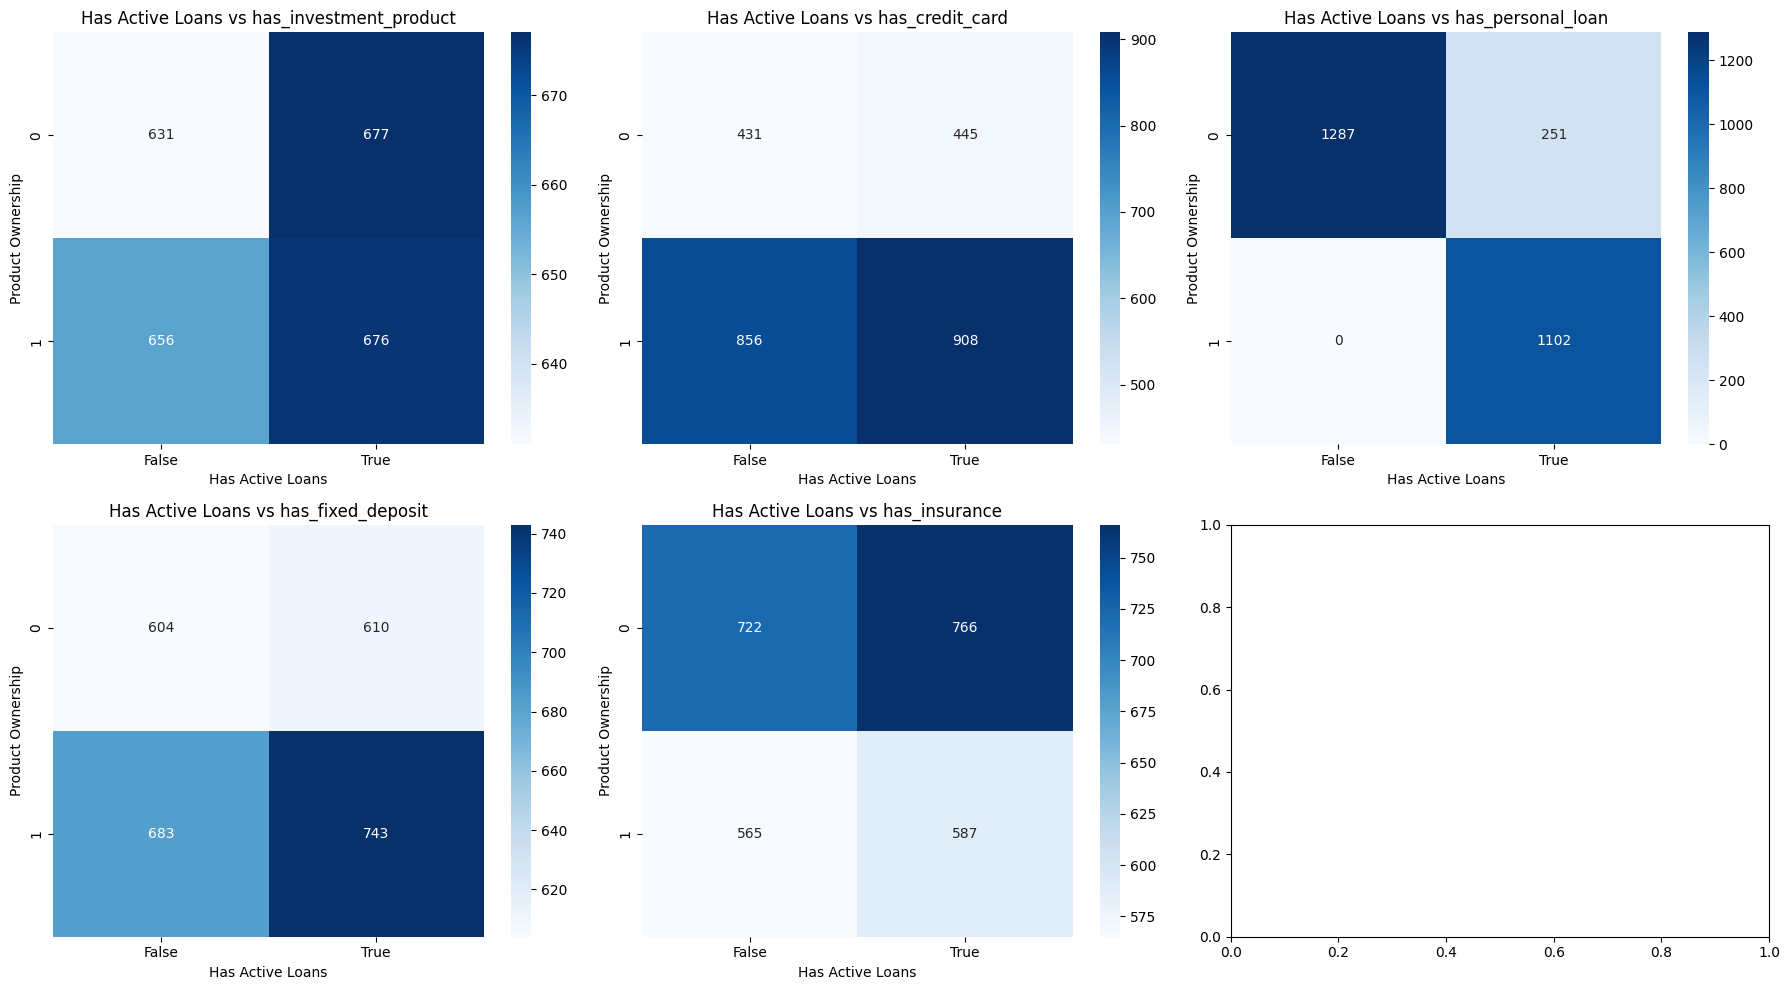

<Figure size 640x480 with 0 Axes>

In [310]:
# 1. Boxplot for Total Loan Amount and Average Loan Amount for Each Product Ownership
product_columns = [
    'has_investment_product', 
    'has_credit_card',  
    'has_personal_loan', 
    'has_fixed_deposit', 
    'has_insurance'
]

# Set up the plot for boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot total loan amount vs product ownership
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    sns.boxplot(x=merged_data[product_col], y=merged_data['total_loan_amount'], ax=axes[row, col])
    axes[row, col].set_title(f'{product_col} vs Total Loan Amount')
    axes[row, col].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[row, col].set_ylabel('Total Loan Amount')

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the plot for average loan amount boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot average loan amount vs product ownership
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    sns.boxplot(x=merged_data[product_col], y=merged_data['avg_loan_amount'], ax=axes[row, col])
    axes[row, col].set_title(f'{product_col} vs Average Loan Amount')
    axes[row, col].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[row, col].set_ylabel('Average Loan Amount')

# Adjust layout
plt.tight_layout()
plt.show()


# 2. Heatmap for has_active_loans vs Product Ownership

# Create a contingency table for has_active_loans vs each product ownership
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    contingency_table_active = pd.crosstab(merged_data[product_col], merged_data['has_active_loans'])
    sns.heatmap(contingency_table_active, annot=True, cmap="Blues", fmt="d", ax=axes[row, col])
    axes[row, col].set_title(f'Has Active Loans vs {product_col}')
    axes[row, col].set_xlabel('Has Active Loans')
    axes[row, col].set_ylabel('Product Ownership')

# Adjust layout
plt.tight_layout()
plt.show()


# Adjust layout
plt.tight_layout()
plt.show()



Features total_loan_amt and avg_loan_amt do not show a significant impact on whether a customer owns any of the products, hence we will exclude it from the modeling process. We will keep has_active_loans, which appears to be strongly correlated with each products' ownership.

### Categorical Feature Distributions

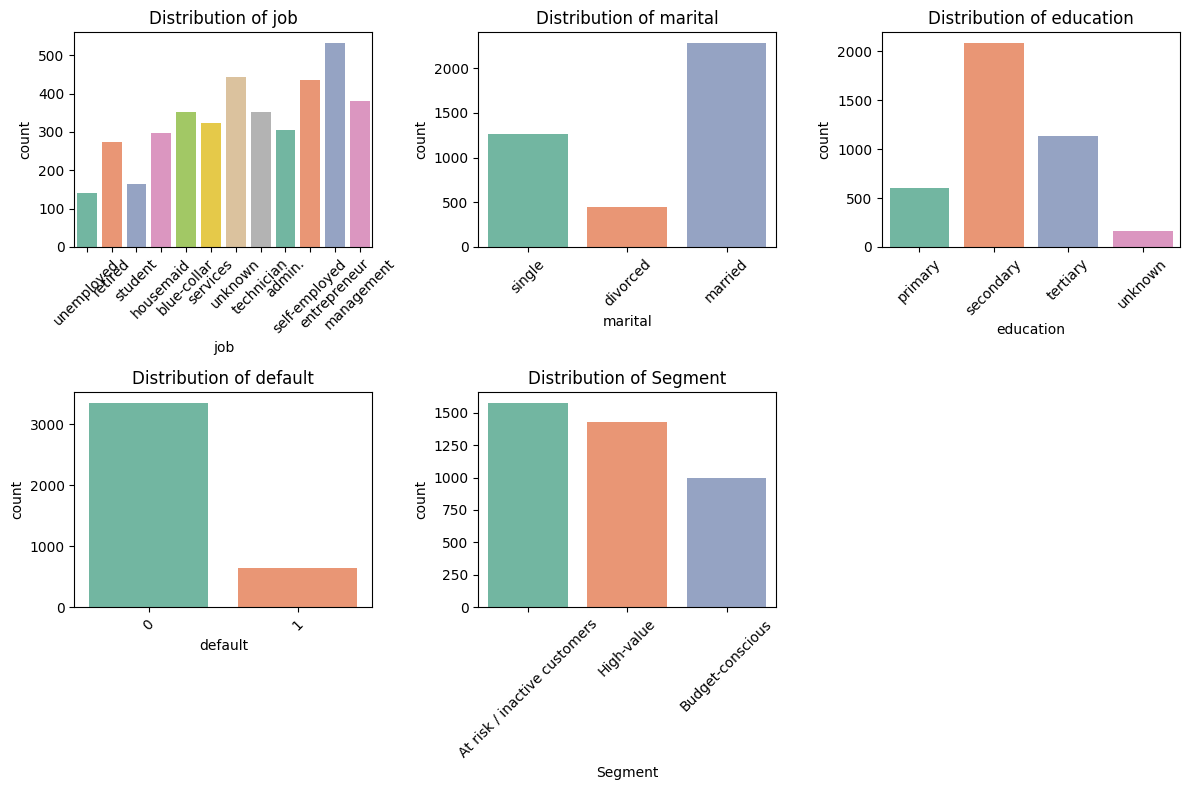

In [311]:
# List of categorical features to analyze
categorical_features = ['job', 'marital', 'education', 'default', 'Segment']

# Plot the distributions of categorical features using bar plots
plt.figure(figsize=(12, 8))

# Loop through each categorical feature to plot
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)  # Adjust number of rows and columns based on your data
    sns.countplot(x=feature, hue=feature, data=df, palette="Set2", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The default feature exhibits significant class imbalance, with the majority of customers classified as non-default. To assess whether this feature holds predictive value for customer product preferences, we will check its correlation with the target variables.

In [312]:
# Check correlation between `default` and other target variables
target_columns = ['has_investment_product', 'has_credit_card', 'has_personal_loan', 'has_fixed_deposit', 'has_insurance']
correlations = df[target_columns].apply(lambda x: x.corr(df['default']))

print(correlations)

has_investment_product   -0.017391
has_credit_card          -0.161344
has_personal_loan         0.014154
has_fixed_deposit        -0.003884
has_insurance            -0.010951
dtype: float64


Given that the correlations are very weak and close to zero, it appears that the default feature does not significantly contribute to predicting product ownership. As a result, we decided to drop this feature from the model.

### Analyzing relationships between features

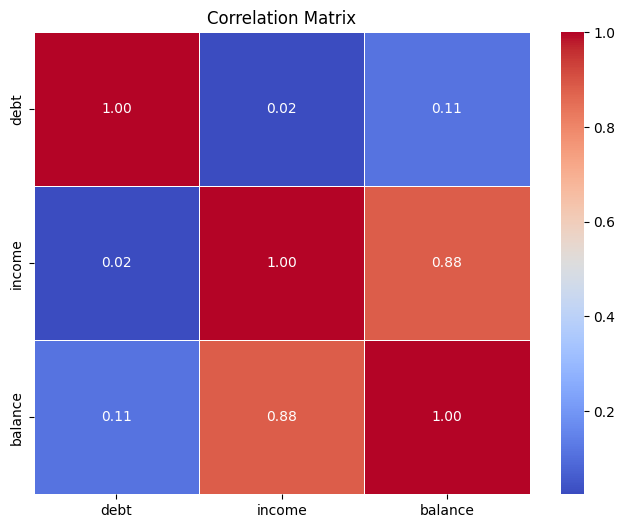

In [313]:
# Define the pairs of features you want to assess correlation for
features_to_check = ['debt', 'income', 'balance',]

# Calculate the correlation matrix for the selected features
correlation_matrix = df[features_to_check].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


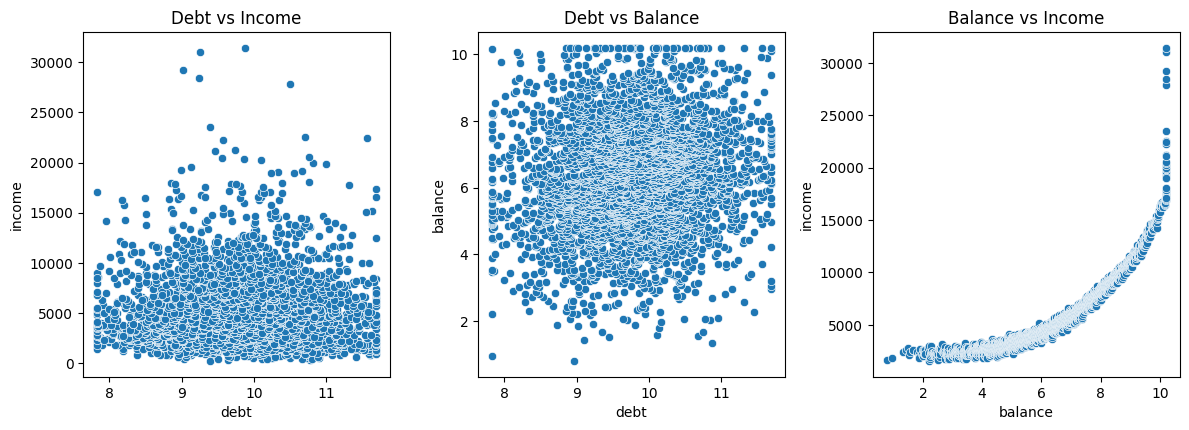

In [314]:
# Plotting scatter plots to visually assess the relationships
plt.figure(figsize=(12, 8))

# Scatter plot for debt vs income
plt.subplot(2, 3, 1)
sns.scatterplot(x='debt', y='income', data=df)
plt.title('Debt vs Income')

# Scatter plot for debt vs balance
plt.subplot(2, 3, 2)
sns.scatterplot(x='debt', y='balance', data=df)
plt.title('Debt vs Balance')

# Scatter plot for balance vs income
plt.subplot(2, 3, 3)
sns.scatterplot(x='balance', y='income', data=df)
plt.title('Balance vs Income')

plt.tight_layout()
plt.show()


In [315]:
# Select relevant features and target variables
features = ['balance', 'income']
targets = ['has_investment_product', 'has_credit_card', 
           'has_personal_loan', 'has_fixed_deposit', 'has_insurance']

# Compute correlation matrix
correlation_matrix = df[features + targets].corr()

# Extract correlations between balance/income and target variables
correlation_with_targets = correlation_matrix.loc[features, targets]

# Display correlation values
print(correlation_with_targets)


         has_investment_product  has_credit_card  has_personal_loan  \
balance                0.043733         0.055731           0.017795   
income                 0.058078         0.110302           0.000442   

         has_fixed_deposit  has_insurance  
balance          -0.019494       0.060266  
income            0.004500       0.060453  


The balance feature is highly correlated with income (0.88), indicating redundancy. Additionally, it shows very weak correlations with the target variables, suggesting it has little predictive value. Given this, balance will be dropped to reduce feature complexity and avoid unnecessary multicollinearity.

### Dropping features

In [316]:
df = df.drop(columns=['balance', 'default', 'num_loans', 'total_loan_amount', 'avg_loan_amount', 'transaction_count', 'avg_transaction_amt', 'avg_transactions_per_month'])

df

,customer_id,age,job,marital,education,debt,income,dependents,has_active_loans,Segment,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
0,217,33,unemployed,single,primary,9.634567,277.46,1,True,At risk / inactive customers,0,0,1,1,0
1,179,32,retired,single,secondary,9.443948,716.15,3,True,At risk / inactive customers,1,1,1,1,0
2,81,20,unemployed,single,secondary,9.980938,539.38,3,True,High-value,1,0,1,0,0
3,50,35,unemployed,single,tertiary,10.769191,269.77,3,NaN,High-value,0,0,0,1,0
4,13,35,student,single,secondary,10.500282,522.33,1,True,At risk / inactive customers,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3281,37,unknown,married,secondary,10.499310,27848.66,2,True,Budget-conscious,1,1,1,1,0
3996,3101,43,unknown,married,secondary,9.243668,28432.42,2,True,Budget-conscious,1,1,1,0,0
3997,3349,61,unknown,married,tertiary,9.014913,29211.87,3,True,Budget-conscious,1,1,1,1,1
3998,2157,48,unknown,married,unknown,9.248816,31063.57,1,False,Budget-conscious,1,0,0,0,1


### Explore product ownership

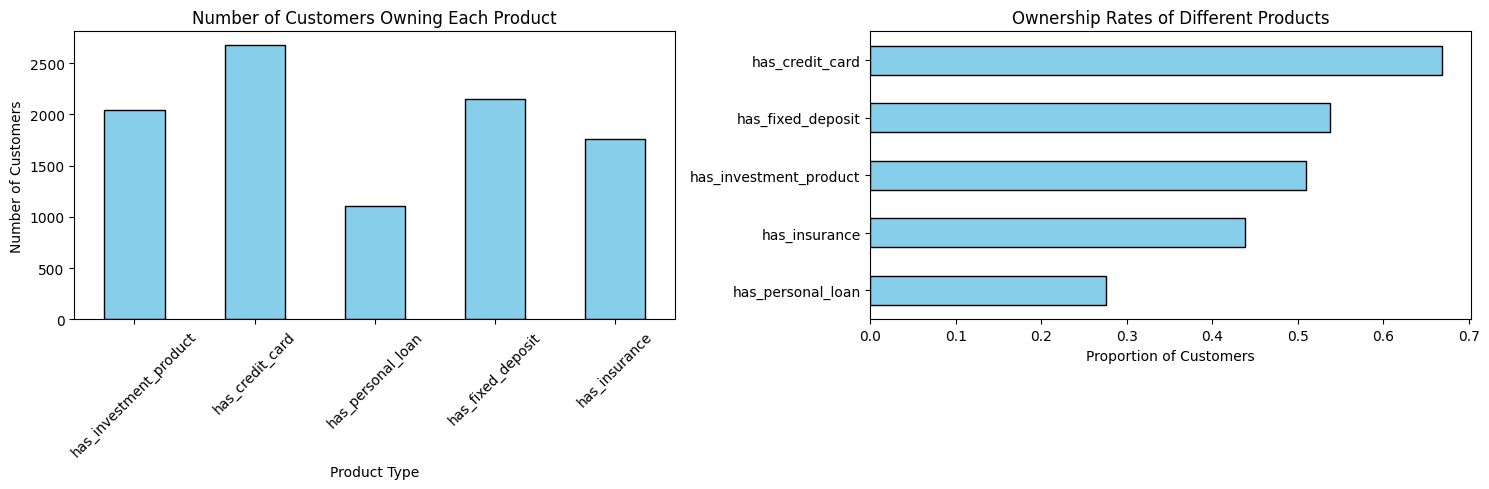

In [317]:
#count customers who have each product
product_counts = products_df.drop(columns=["customer_id"]).sum()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Number of customers owning each product
product_counts.plot(kind="bar", color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Number of Customers Owning Each Product")
axes[0].set_xlabel("Product Type")
axes[0].set_ylabel("Number of Customers")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Ownership rates of different products
products_df.drop(columns="customer_id").mean().sort_values().plot(kind="barh", ax=axes[1], color="skyblue", edgecolor="black")
axes[1].set_title("Ownership Rates of Different Products")
axes[1].set_xlabel("Proportion of Customers")

# Show the plots
plt.tight_layout()
plt.show()


Given the slight imbalance in the distribution of product ownership, we will employ tree-based models, such as Random Forest and XGBoost, for our product recommendation system. These models are well-suited to handle class imbalance, as they are less sensitive to skewed class distributions and can effectively capture complex patterns in the data.

## Baseline model

In [318]:
df.describe()

,customer_id,age,debt,income,dependents,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,39.802000,9.810390,4926.078810,2.339500,0.509750,0.669250,0.275500,0.537750,0.438750
std,1154.844867,10.342608,0.815035,3288.695279,1.299485,0.499967,0.470542,0.446822,0.498635,0.496296
min,1.000000,18.000000,7.831857,200.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,9.241495,2692.537500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,39.000000,9.819754,4082.075000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3000.250000,47.000000,10.374081,6256.390000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4000.000000,77.000000,11.685510,31448.860000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [319]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


df = df.drop(columns=['income', 'debt', 'marital'])

# Define feature and target columns
feature_cols = [
    "age", "job", "education", "dependents", "has_active_loans", "Segment"    
]

target_cols = [
    "has_investment_product", "has_credit_card",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

X = df[feature_cols]
y = df[target_cols]

# Identify categorical and numerical columns
categorical_features = ['job', 'education', 'Segment']
numerical_features = list(set(feature_cols) - set(categorical_features))

# Preprocessing: Imputation for missing values, One-Hot Encoding for categorical, Scaling for numerical
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),  # Impute missing numerical values
        ("scaler", StandardScaler())  # Scale numerical features
    ]), numerical_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing categorical values
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
    ]), categorical_features)
])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### XGBoost with SMOTE and undersampling

Marital status and levels of income and debt are less relevant to predicting product ownership and were hence dropped.

In [320]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve


# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.02, 0.03],  # Step size shrinking to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used for each tree
    'gamma': [0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition
}

# Initialize the model
model = XGBClassifier(random_state=42)

# Store the performance metrics for each target
performance_metrics_all_targets = []

# Stratified KFold cross-validation for ensuring balanced splits
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Iterate over all target columns
for target in target_cols:
    # Extract features and target for the current iteration
    X = df[feature_cols]
    y = df[target]
    
    # Preprocess data (Imputation, Scaling, Encoding)
    X_processed = preprocessor.fit_transform(X)
    
    # Store metrics for this target
    recall_list = []
    f1_list = []

    # Split data into training and validation sets (using Stratified KFold)
    for train_idx, val_idx in kf.split(X_processed, y):
        X_train, X_val = X_processed[train_idx], X_processed[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Adjust the param_grid for the current target based on scale_pos_weight
        target_param_grid = param_grid.copy()

        # Set up RandomizedSearchCV
        random_search = RandomizedSearchCV(estimator=model,
                                           param_distributions=target_param_grid,
                                           n_iter=10,  # Number of iterations for the random search
                                           scoring='f1',  # Optimize for recall or F1-score
                                           cv=3,  # Stratified KFold
                                           verbose=1,
                                           n_jobs=-1,  # Parallel processing
                                           random_state=42)

        # Fit the RandomizedSearchCV model on the training data
        random_search.fit(X_train, y_train)

        # Get the best model from the random search
        best_model = random_search.best_estimator_

        # Get probability predictions instead of class labels
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]

        # Compute precision-recall curve
        precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_pred_proba)

        # Compute F1-scores for different thresholds
        f1_scores = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-6)

        # Select the threshold that maximizes F1-score
        best_threshold = thresholds[np.argmax(f1_scores)]

        # Apply the optimized threshold
        y_pred = (y_pred_proba > best_threshold).astype(int)

        # Calculate recall and F1-score after threshold tuning
        precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average='binary')
        # Append the metrics to the lists
        recall_list.append(recall)
        f1_list.append(f1)

    # Calculate the average recall and F1-score for this target
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    # Store the averaged metrics for the current target
    performance_metrics_all_targets.append({
        "Target": target,
        "Average Recall": avg_recall,
        "Average F1-Score": avg_f1,
    })

# Convert the metrics into a DataFrame for better readability
performance_df_all_targets = pd.DataFrame(performance_metrics_all_targets)

# Display the performance metrics for all targets
print(performance_df_all_targets)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
                   Target  Average Recall  Average F1-Score
0  has_investment_product